In [35]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import datascience as ds
np.random.seed(42)  
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('fivethirtyeight')

## Data processing

In [2]:
pm = "data/NYC_AQ/NYC_PM_Part1.csv"
pmdata = pd.read_csv('NYC_Pilot2_PM_Part1.csv') #contents of data)
pmdata.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,0,23.7,57.3,4.508813
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,0,0,0,23.7,57.8,5.462420
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,0,0,0,23.7,57.8,5.154881
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,0,0,0,23.6,57.6,4.508813
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,0,0,0,23.6,57.5,5.539503


In [3]:
pmdata = \
pmdata[(pmdata['latitude']!=0) & \
       (pmdata['longitude'] !=0)]

In [87]:
#!pip install pygeohash
import  pygeohash as gh



In [88]:
geohash_precision=6

pmdata['geohash'] = pmdata.apply(lambda x:gh.encode(x.latitude, x.longitude, precision=geohash_precision), axis=1)

In [4]:
gdf_pm25=gpd.GeoDataFrame(pmdata, geometry=gpd.points_from_xy(pmdata.longitude, pmdata.latitude))
gdf_pm25=gdf_pm25.set_crs(epsg=4326) 

In [5]:
geojsonfile = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
# Create a GeoDataFrame from the DataFrame by converting lat/lon to geometry
gdf_neighbourhoods = gpd.read_file(geojsonfile)
#gdf_neighbourhoods.crs

In [6]:
from geopandas.tools import sjoin
# Perform spatial join
joined_gdf_pm25 = sjoin(gdf_pm25, gdf_neighbourhoods, predicate="within")
joined_gdf_pm25.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin23,temperature,humidity,pm25,geometry,index_right,neighborhood,boroughCode,borough,@id
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,23.7,57.3,4.508813,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,23.7,57.8,5.462420,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,23.7,57.8,5.154881,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,23.6,57.6,4.508813,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,23.6,57.5,5.539503,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...


In [7]:
type(joined_gdf_pm25)


geopandas.geodataframe.GeoDataFrame

In [8]:
joined_gdf_pm25.shape

(169995, 37)

In [9]:
n=len(pd.unique(joined_gdf_pm25['neighborhood']))
n

48

In [10]:
# Select columns to copy
columns_to_copy = ['neighborhood','latitude', 'longitude', 'pm25']  # Replace with the names of the 
new_joined_gdf_pm25_2 = joined_gdf_pm25[columns_to_copy].copy()
type(new_joined_gdf_pm25_2)

pandas.core.frame.DataFrame

## Data Visualization

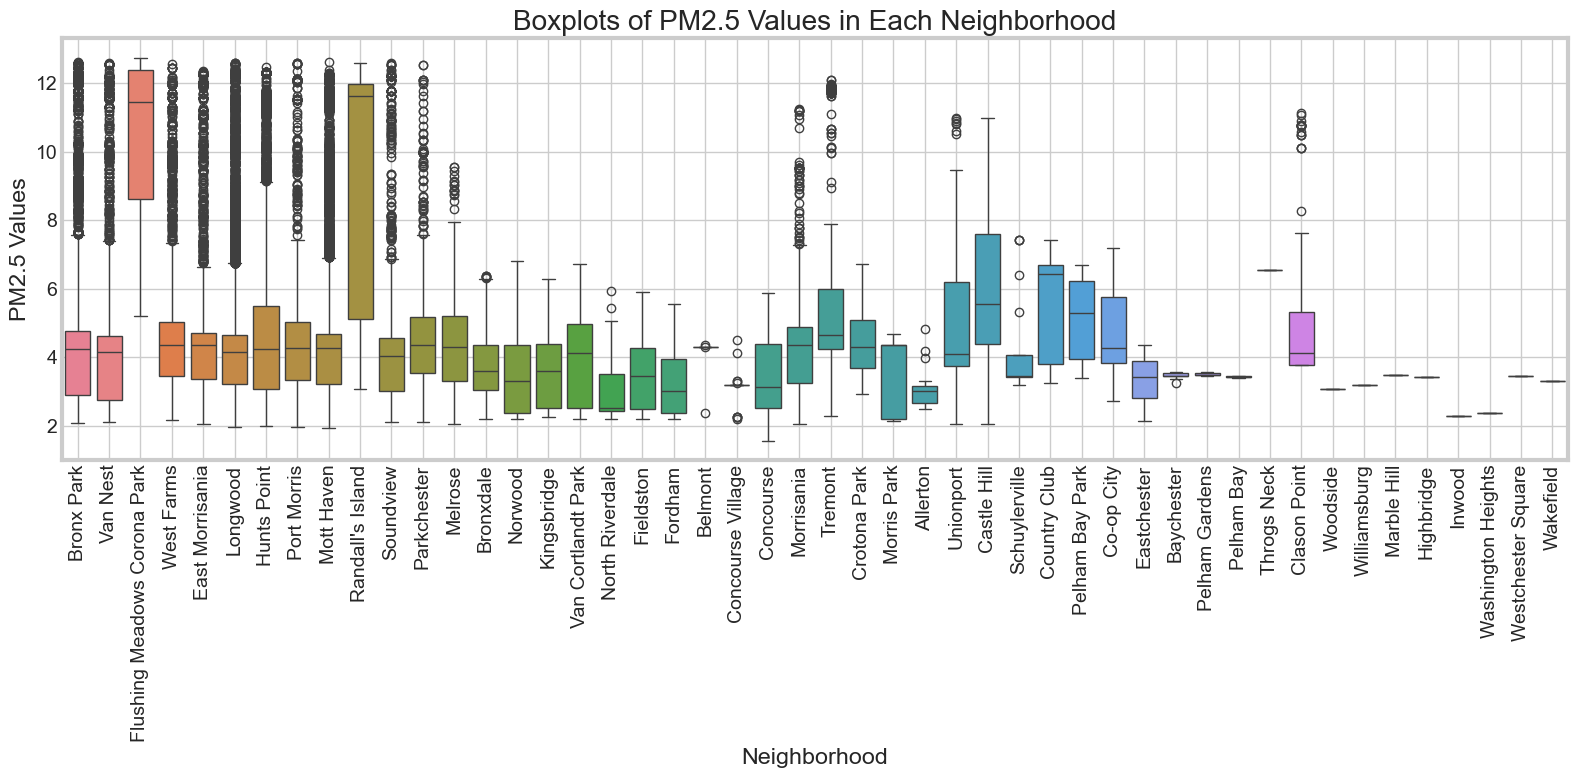

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set_style("whitegrid")

# Plot boxplots for PM2.5 values in each neighborhood
plt.figure(figsize=(16, 8))  # Set a wider figure size

sns.boxplot(data=new_joined_gdf_pm25_2, x='neighborhood', y='pm25', hue='neighborhood')

# Add labels and title
plt.xlabel('Neighborhood')
plt.ylabel('PM2.5 Values')
plt.title('Boxplots of PM2.5 Values in Each Neighborhood')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


## Sampling Data

In [13]:
import time
start=time.time()
sample_base= new_joined_gdf_pm25_2.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=0.4))
end=time.time()
print("excution time is:", end-start)
print('sample size:',sample_base.shape)
sample_base.head()

sample size: (67996, 4)


,neighborhood,latitude,longitude,pm25
95474,Allerton,40.862965,-73.866020,3.019981
95499,Allerton,40.862930,-73.866020,3.274350
95511,Allerton,40.862946,-73.866028,2.713955
95502,Allerton,40.862923,-73.866028,2.674112
95530,Allerton,40.862984,-73.866013,2.625572


In [14]:
sample2=sample_base['neighborhood'].value_counts()
sample2=sample2.reset_index()
sample2.colums=['neighborhood','count']
sample2['neighborhood']=sample2['neighborhood'].astype(str)
sample2.head(2)

C:\Users\Manar Anwer\AppData\Local\Temp\ipykernel_4420\3871528025.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sample2.colums=['neighborhood','count']


,neighborhood,count
0,Longwood,17009
1,Bronx Park,15798


In [15]:
original=joined_gdf_pm25['neighborhood'].value_counts()
original=original.reset_index()
original.colums=['neighborhood','count']
original['neighborhood']=original['neighborhood'].astype(str)
original.head(2)

C:\Users\Manar Anwer\AppData\Local\Temp\ipykernel_4420\887117895.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original.colums=['neighborhood','count']


,neighborhood,count
0,Longwood,42523
1,Bronx Park,39495


In [ ]:
import folium
original["neighborhood"].astype(str)
geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
heatmap_scale=list()
threshold=[10,20,50,70,85,100]
for i in threshold:
    heatmap_scale.append(int(original['count'].max()*(i/100.0)))
map_original=folium.Map(location=[40.730610,-73.935242], zoom_start=10)
#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geojsonfile,#Assign geo_data to your geojson file
    name = "choropleth",
    data = original,#Assign dataset of interest
    columns = ["neighborhood","count"],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.neighborhood',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'neighborhood').add_to(map_original)

map_original


In [ ]:
import folium
sample2["neighborhood"].astype(str)
geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
heatmap_scale=list()
threshold=[10,20,50,70,85,100]
for i in threshold:
    heatmap_scale.append(int(sample2['count'].max()*(i/100.0)))
map_sample2=folium.Map(location=[40.730610,-73.935242], zoom_start=10)
#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geojsonfile,#Assign geo_data to your geojson file
    name = "choropleth",
    data = sample2,#Assign dataset of interest
    columns = ["neighborhood","count"],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.neighborhood',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'neighborhood').add_to(map_sample2)

map_sample2

from the above two maps we can see that our sample is actually representative of the population that we have. 

## Feature Scaling

In [17]:
from sklearn.preprocessing import StandardScaler
feature_columns = ["latitude", "longitude","pm25"]
# Scale these features
scaler = StandardScaler()
scaled_features=scaler.fit_transform(sample_base[feature_columns])
scaled_features

array([[ 2.13655049,  1.36915452, -0.72277806],
       [ 2.13451673,  1.36915452, -0.58122004],
       [ 2.13544645,  1.3687416 , -0.89308433],
       ..., 
       [ 0.82518472,  1.0241552 , -0.96710458],
       [ 0.76242882,  1.00882534, -0.83894293],
       [ 0.71437407,  0.66150332,  0.34708261]])

## K-means

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_features)

samplek=sample_base.copy()
samplek.loc[:, 'label'] = kmeans.labels_
samplek.head()

,neighborhood,latitude,longitude,pm25,label
95474,Allerton,40.862965,-73.866020,3.019981,0
95499,Allerton,40.862930,-73.866020,3.274350,0
95511,Allerton,40.862946,-73.866028,2.713955,0
95502,Allerton,40.862923,-73.866028,2.674112,0
95530,Allerton,40.862984,-73.866013,2.625572,0


In [19]:
samplek.groupby('label').size()

label
0    22835
1    39349
2     5812
dtype: int64

In [20]:
type(gdf_neighbourhoods)

geopandas.geodataframe.GeoDataFrame

In [21]:
gdf_neighbourhoods.head()

,neighborhood,boroughCode,borough,@id,geometry
0,Allerton,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.84860 40.87167, -73.84582 40.870..."
1,Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.74333 40.73888, -73.74371 40.739..."
2,Arden Heights,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.16983 40.56108, -74.16982 40.561..."
3,Arlington,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.15975 40.64142, -74.15998 40.641..."
4,Arrochar,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.06078 40.59319, -74.06079 40.593..."


In [22]:
type(samplek)

pandas.core.frame.DataFrame

In [23]:
samplek.head()

,neighborhood,latitude,longitude,pm25,label
95474,Allerton,40.862965,-73.866020,3.019981,0
95499,Allerton,40.862930,-73.866020,3.274350,0
95511,Allerton,40.862946,-73.866028,2.713955,0
95502,Allerton,40.862923,-73.866028,2.674112,0
95530,Allerton,40.862984,-73.866013,2.625572,0


In [24]:
import geopandas as gpd
gdf_pm25_result_k = gdf_neighbourhoods.merge(samplek, left_on='neighborhood', right_on='neighborhood', how='left')
gdf_pm25_result_k['label'] = gdf_pm25_result_k['label'].fillna(-1)
type(gdf_pm25_result_k)

geopandas.geodataframe.GeoDataFrame

In [25]:
type(gdf_pm25_result_k)

geopandas.geodataframe.GeoDataFrame

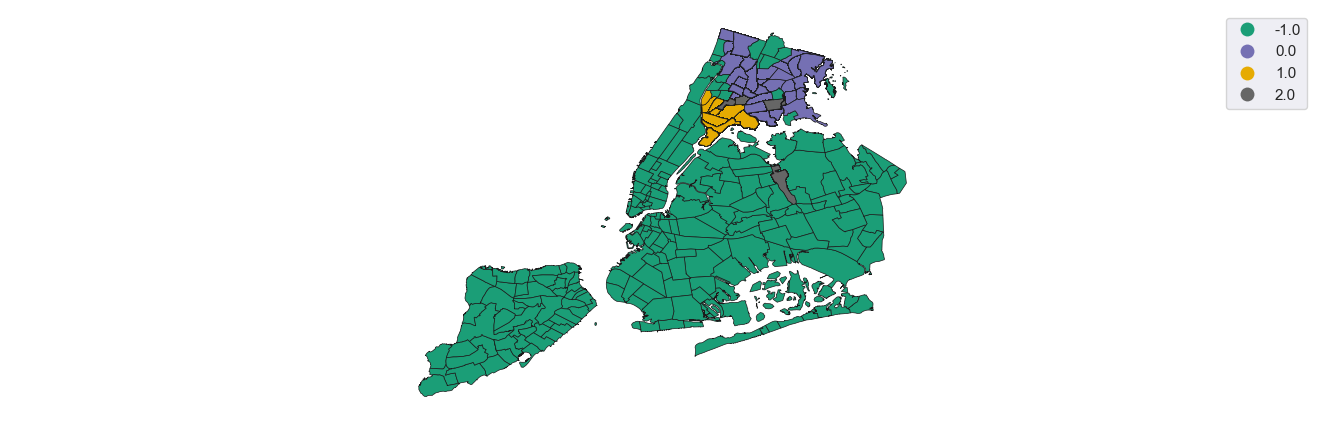

In [26]:
# setup the figure
f, ax = plt.subplots()

# plot, coloring by label column
# specify categorical data and add legend
gdf_pm25_result_k.plot(
    column="label",
    cmap="Dark2",
    categorical=True,
    legend=True,
    edgecolor="k",
    lw=0.5,
    ax=ax,
)


ax.set_axis_off()
plt.axis("equal");

In [73]:
from sklearn.preprocessing import StandardScaler
feature_columns = ["latitude", "longitude","pm25"]
# Scale these features
scaler = StandardScaler()
scaled_features=scaler.fit_transform(new_joined_gdf_pm25_2[feature_columns])
scaled_features= pd.DataFrame(scaled_features)
scaled_features

,0,1,2
0,1.247148,1.200472,0.110286
1,1.246916,1.200472,0.641630
2,1.245812,1.198096,0.470271
3,1.245812,1.198096,0.110286
4,1.245812,1.198096,0.684580
...,...,...,...
169990,0.171082,-2.021579,-0.495496
169991,1.897260,-1.554217,-1.124756
169992,1.650854,-1.600705,-1.082711
169993,0.789537,2.270788,-0.471528


In [75]:
new=new_joined_gdf_pm25_2
# Fit and transform the scaler on the specified columns
features_scaled = scaler.fit_transform(new[['latitude', 'longitude', 'pm25']])

# Update the DataFrame with the scaled values
new['latitude'] = features_scaled[:, 0]
new['longitude'] = features_scaled[:, 1]
new['pm25'] = features_scaled[:, 2]
new

,neighborhood,latitude,longitude,pm25
0,Bronx Park,1.247148,1.200472,0.110286
1,Bronx Park,1.246916,1.200472,0.641630
2,Bronx Park,1.245812,1.198096,0.470271
3,Bronx Park,1.245812,1.198096,0.110286
4,Bronx Park,1.245812,1.198096,0.684580
...,...,...,...,...
161398,Highbridge,0.171082,-2.021579,-0.495496
161454,Inwood,1.897260,-1.554217,-1.124756
161455,Washington Heights,1.650854,-1.600705,-1.082711
161459,Westchester Square,0.789537,2.270788,-0.471528


## Silhouette Index for K-means


Training Time for k=2, Sample Ratio=0.1: 0.03 seconds
Training Time for k=2, Sample Ratio=0.2: 0.03 seconds
Training Time for k=2, Sample Ratio=0.3: 0.05 seconds
Training Time for k=2, Sample Ratio=0.6: 0.07 seconds
Training Time for k=3, Sample Ratio=0.1: 0.05 seconds
Training Time for k=3, Sample Ratio=0.2: 0.05 seconds
Training Time for k=3, Sample Ratio=0.3: 0.06 seconds
Training Time for k=3, Sample Ratio=0.6: 0.08 seconds
Training Time for k=4, Sample Ratio=0.1: 0.05 seconds
Training Time for k=4, Sample Ratio=0.2: 0.06 seconds
Training Time for k=4, Sample Ratio=0.3: 0.07 seconds
Training Time for k=4, Sample Ratio=0.6: 0.08 seconds
Training Time for k=5, Sample Ratio=0.1: 0.05 seconds
Training Time for k=5, Sample Ratio=0.2: 0.06 seconds
Training Time for k=5, Sample Ratio=0.3: 0.07 seconds
Training Time for k=5, Sample Ratio=0.6: 0.08 seconds
Training Time for k=8, Sample Ratio=0.1: 0.05 seconds
Training Time for k=8, Sample Ratio=0.2: 0.07 seconds
Training Time for k=8, Sampl

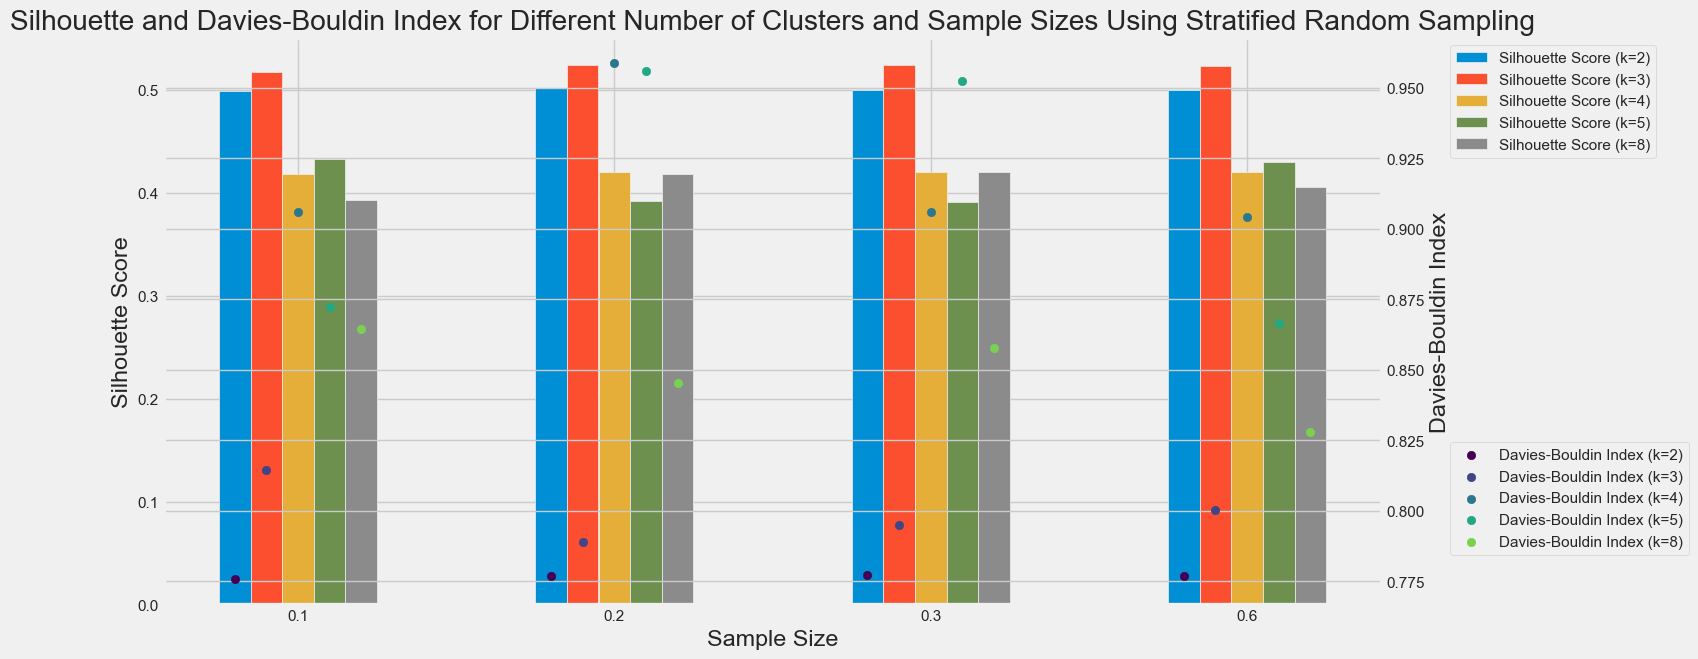

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Assuming 'new_joined_gdf_pm25_2' is your DataFrame containing the data

# Define sample ratios and number of clusters (k) to test
sample_ratios = [0.1,0.2,0.3,0.6]
k_values = [2,3,4,5,8]
silhouette_results = {k: [] for k in k_values}
davies_results = {k: [] for k in k_values}


# Iterate over each number of clusters
for k in k_values:
    # Create KMeans object inside the loop to avoid reuse
    kmeans = KMeans(n_clusters=k, random_state=1)
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        start_time = time.time()
        features_samples = new.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=ratio))
        features_scaled_sample = features_samples[['pm25', 'longitude', 'latitude']]
        
        labels = kmeans.fit_predict(features_scaled_sample)
        end_time = time.time()
        training_time = end_time - start_time

        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        silhouette_avg = silhouette_score(features_scaled_sample, labels)
        davies_avg = davies_bouldin_score(features_scaled_sample, labels)
        silhouette_results[k].append(silhouette_avg)
        davies_results[k].append(davies_avg)

                # Print training time for each case
        print(f"Training Time for k={k}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each sample ratio for silhouette scores
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (k, scores) in enumerate(silhouette_results.items()):
    # Offset each k's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'Silhouette Score (k={k})')

# Plot Davies-Bouldin Index on secondary y-axis
ax2 = ax.twinx()
for i, (k, scores) in enumerate(davies_results.items()):
    ax2.scatter(index + i * bar_width, scores, marker='o', label=f'Davies-Bouldin Index (k={k})', color=plt.cm.viridis(i / len(k_values)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette and Davies-Bouldin Index for Different Number of Clusters and Sample Sizes Using Stratified Random Sampling')
ax.set_xticks(index + bar_width * (len(k_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()


## DBSCAN

## Silhouette Index for DBSCAN


Training Time for epsilon=0.3, Sample Ratio=0.1: 0.43 seconds
Training Time for epsilon=0.3, Sample Ratio=0.2: 1.28 seconds
Training Time for epsilon=0.3, Sample Ratio=0.4: 3.95 seconds
Training Time for epsilon=0.3, Sample Ratio=0.6: 8.02 seconds
Training Time for epsilon=0.5, Sample Ratio=0.1: 0.66 seconds
Training Time for epsilon=0.5, Sample Ratio=0.2: 2.25 seconds
Training Time for epsilon=0.5, Sample Ratio=0.4: 8.04 seconds
Training Time for epsilon=0.5, Sample Ratio=0.6: 14.43 seconds
Training Time for epsilon=0.7, Sample Ratio=0.1: 0.96 seconds
Training Time for epsilon=0.7, Sample Ratio=0.2: 3.39 seconds
Training Time for epsilon=0.7, Sample Ratio=0.4: 19.87 seconds
Training Time for epsilon=0.7, Sample Ratio=0.6: 20.27 seconds
Training Time for epsilon=0.9, Sample Ratio=0.1: 1.32 seconds
Training Time for epsilon=0.9, Sample Ratio=0.2: 4.25 seconds
Training Time for epsilon=0.9, Sample Ratio=0.4: 15.00 seconds
Training Time for epsilon=0.9, Sample Ratio=0.6: 27.58 seconds


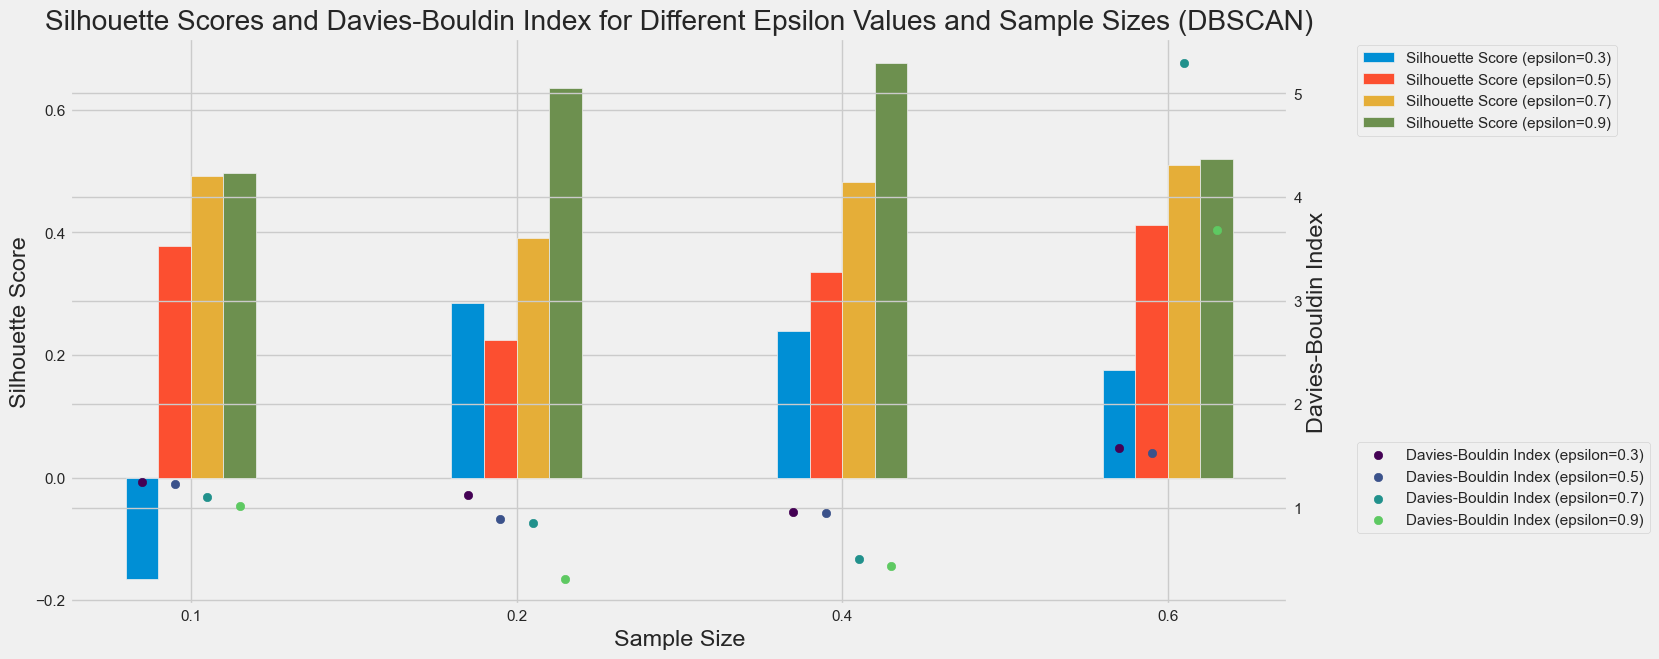

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Assuming 'new_joined_gdf_pm25_2' is your DataFrame containing the data

# Define sample ratios and epsilon values to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
epsilon_values = [0.3, 0.5, 0.7, 0.9]  # Different epsilon values to test
silhouette_results = {epsilon: [] for epsilon in epsilon_values}
davies_results = {epsilon: [] for epsilon in epsilon_values}


# Iterate over each epsilon value
for epsilon in epsilon_values:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        start_time = time.time()
        features_samples = new.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=ratio))
        features_scaled_sample = features_samples[['pm25', 'longitude', 'latitude']]
        
        # Run DBSCAN clustering on the sampled and scaled features
        dbscan = DBSCAN(eps=epsilon, min_samples=10)
        labels = dbscan.fit_predict(features_scaled_sample)
        end_time = time.time()
        training_time = end_time - start_time

        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[epsilon].append(silhouette_avg)
            davies_results[epsilon].append(davies_avg)
        else:
            silhouette_results[epsilon].append(None)  # Only noise points found
            davies_results[epsilon].append(None)

        # Print training time for each case
        print(f"Training Time for epsilon={epsilon}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each epsilon value for silhouette scores
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (epsilon, scores) in enumerate(silhouette_results.items()):
    # Offset each epsilon's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'Silhouette Score (epsilon={epsilon})')

# Plot Davies-Bouldin Index on secondary y-axis
ax2 = ax.twinx()
for i, (epsilon, scores) in enumerate(davies_results.items()):
    ax2.scatter(index + i * bar_width, scores, marker='o', label=f'Davies-Bouldin Index (epsilon={epsilon})', color=plt.cm.viridis(i / len(epsilon_values)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores and Davies-Bouldin Index for Different Epsilon Values and Sample Sizes (DBSCAN)')
ax.set_xticks(index + bar_width * (len(epsilon_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()

Training Time for min_samples=2, Sample Ratio=0.1: 1.14 seconds
Training Time for min_samples=2, Sample Ratio=0.2: 4.18 seconds
Training Time for min_samples=2, Sample Ratio=0.4: 14.28 seconds
Training Time for min_samples=2, Sample Ratio=0.6: 27.83 seconds
Training Time for min_samples=5, Sample Ratio=0.1: 1.17 seconds
Training Time for min_samples=5, Sample Ratio=0.2: 4.44 seconds
Training Time for min_samples=5, Sample Ratio=0.4: 14.01 seconds
Training Time for min_samples=5, Sample Ratio=0.6: 26.15 seconds
Training Time for min_samples=10, Sample Ratio=0.1: 1.34 seconds
Training Time for min_samples=10, Sample Ratio=0.2: 4.48 seconds
Training Time for min_samples=10, Sample Ratio=0.4: 14.33 seconds
Training Time for min_samples=10, Sample Ratio=0.6: 46.72 seconds
Training Time for min_samples=20, Sample Ratio=0.1: 1.16 seconds
Training Time for min_samples=20, Sample Ratio=0.2: 4.26 seconds
Training Time for min_samples=20, Sample Ratio=0.4: 19.48 seconds
Training Time for min_samp

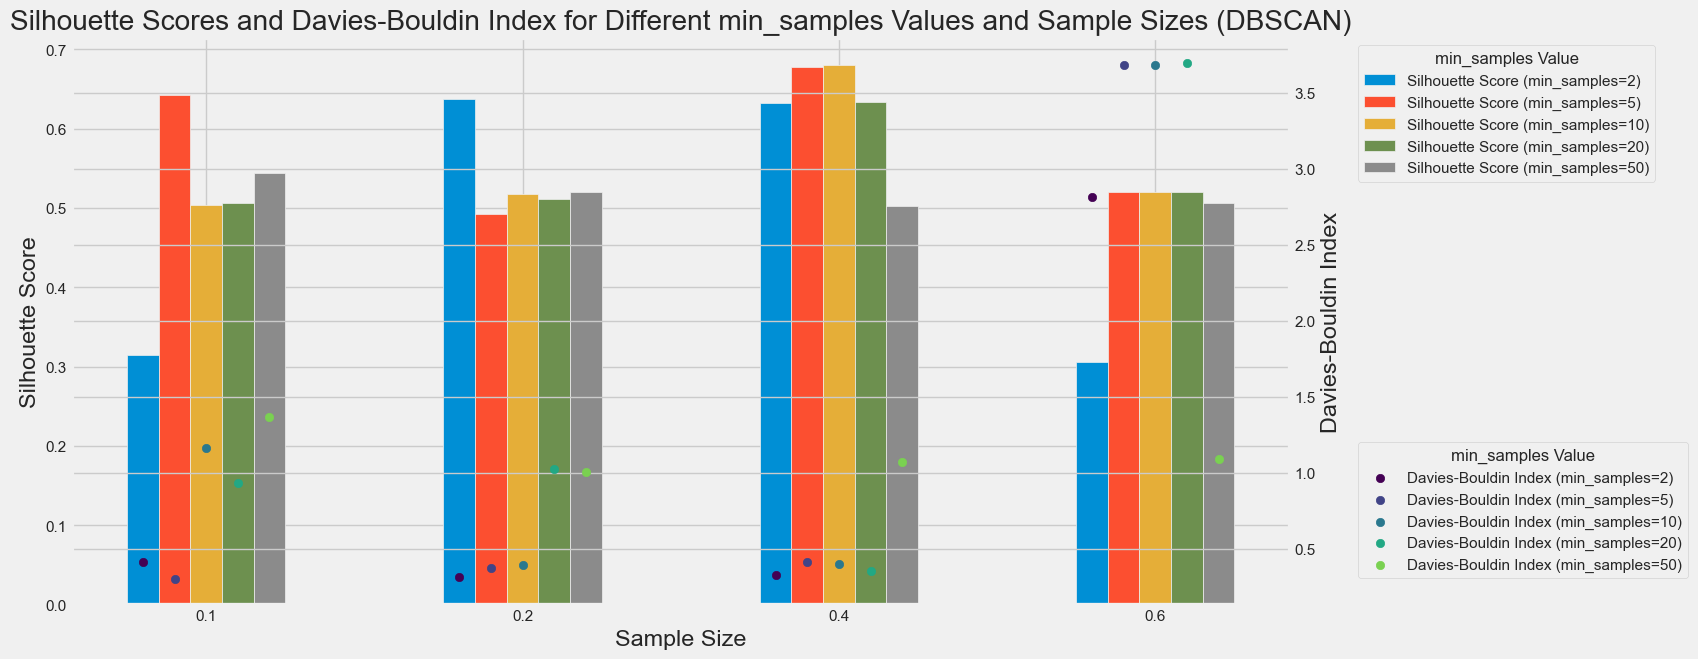

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time


# Define sample ratios and min_samples values to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
min_samples_values = [2, 5, 10, 20, 50]  # Different min_samples values to test
epsilon = 0.9  # Fixed epsilon value
silhouette_results = {min_samples: [] for min_samples in min_samples_values}
davies_results = {min_samples: [] for min_samples in min_samples_values}

# Iterate over each min_samples value
for min_samples in min_samples_values:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        start_time = time.time()
        features_samples = new.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=ratio))
        features_scaled_sample = features_samples[['pm25', 'longitude', 'latitude']]
        # Scale the features of the sample
        # Run DBSCAN clustering on the sampled and scaled features
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        labels = dbscan.fit_predict(features_scaled_sample)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[min_samples].append(silhouette_avg)
            davies_results[min_samples].append(davies_avg)
        else:
            silhouette_results[min_samples].append(None)  # Only noise points found
            davies_results[min_samples].append(None)

        # Print training time for each case
        print(f"Training Time for min_samples={min_samples}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each min_samples value for silhouette scores
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (min_samples, scores) in enumerate(silhouette_results.items()):
    # Offset each min_samples's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'Silhouette Score (min_samples={min_samples})')

# Plot Davies-Bouldin Index on secondary y-axis
ax2 = ax.twinx()
for i, (min_samples, scores) in enumerate(davies_results.items()):
    ax2.scatter(index + i * bar_width, scores, marker='o', label=f'Davies-Bouldin Index (min_samples={min_samples})', color=plt.cm.viridis(i / len(min_samples_values)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores and Davies-Bouldin Index for Different min_samples Values and Sample Sizes (DBSCAN)')
ax.set_xticks(index + bar_width * (len(min_samples_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)

# Adjust legend position
ax.legend(title='min_samples Value', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='min_samples Value', bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()

## OPTICS

## Silhouette Index for OPTICS

C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.1: 9.20 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.2: 32.33 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.4: 152.04 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.6: 226.84 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.1: 14.17 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.2: 39.36 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.4: 140.38 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.6: 315.00 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.1: 9.12 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.2: 25.66 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.4: 94.93 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.6: 224.08 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.1: 9.28 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.2: 25.98 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.4: 95.17 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.6: 223.63 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.1: 14.30 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.2: 39.84 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.4: 138.89 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.6: 313.76 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.1: 10.04 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.2: 27.37 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.4: 98.25 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.6: 298.79 seconds


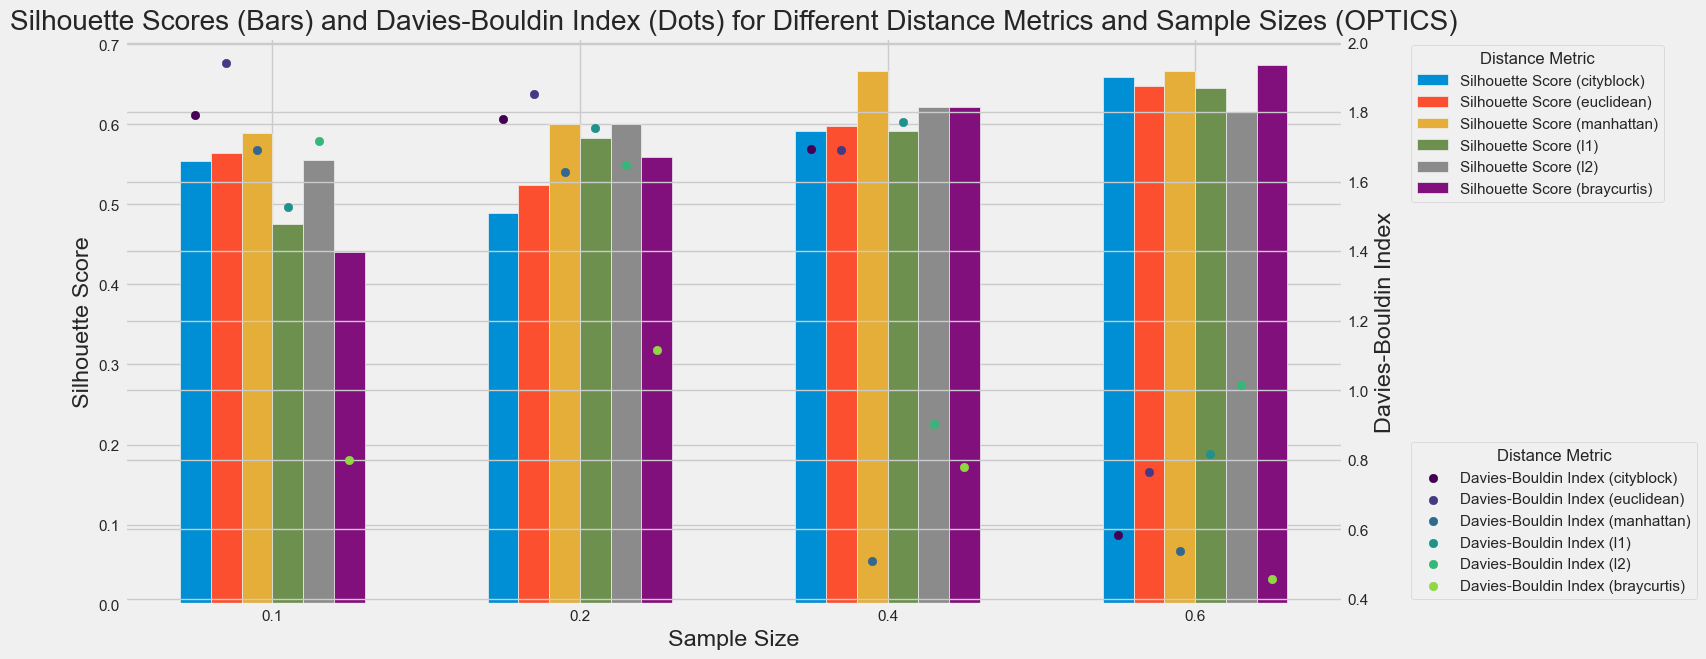

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Define sample ratios and distance metrics to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
distance_metrics = ['cityblock', 'euclidean', 'manhattan', 'l1', 'l2', 'braycurtis']
silhouette_results = {metric: [] for metric in distance_metrics}
davies_results = {metric: [] for metric in distance_metrics}
training_times = {metric: [] for metric in distance_metrics}

# Sample the data once for all iterations
# Assuming 'scaled_features' is your DataFrame containing the scaled data

# Iterate over each distance metric
for metric in distance_metrics:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        start_time = time.time()
        # Sample a fraction of the data based on the 
        features_samples = new.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=ratio))
        features_scaled_sample = features_samples[['pm25', 'longitude', 'latitude']]   
        
        # Run OPTICS clustering on the sampled and scaled features
        optics = OPTICS(min_samples=2, xi=0.05, min_cluster_size=0.1, metric=metric)
        optics.fit(features_scaled_sample)
        labels = optics.labels_
        end_time = time.time()
        training_time = end_time - start_time
        
        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[metric].append(silhouette_avg)
            davies_results[metric].append(davies_avg)
            training_times[metric].append(training_time)
        else:
            silhouette_results[metric].append(None)  # Only noise points found
            davies_results[metric].append(None)
            training_times[metric].append(None)

        # Print training time for each case
        print(f"Training Time for metric={metric}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for silhouette scores for each distance metric
bar_width = 0.1
index = np.arange(len(sample_ratios))
for i, metric in enumerate(distance_metrics):
    ax.bar(index + i * bar_width, silhouette_results[metric], bar_width, label=f'Silhouette Score ({metric})')

# Plot Davies-Bouldin Index on secondary y-axis as dots
ax2 = ax.twinx()
for i, metric in enumerate(distance_metrics):
    ax2.scatter(index + i * bar_width, davies_results[metric], marker='o', label=f'Davies-Bouldin Index ({metric})', color=plt.cm.viridis(i / len(distance_metrics)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores (Bars) and Davies-Bouldin Index (Dots) for Different Distance Metrics and Sample Sizes (OPTICS)')
ax.set_xticks(index + bar_width * (len(distance_metrics) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='Distance Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='Distance Metric', bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()


## Optimizing min_Samples in OPTICS

C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.1: 17.16 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.2: 41.02 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.4: 189.56 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.6: 478.11 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.1: 29.54 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.2: 56.14 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.4: 273.98 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.6: 487.39 seconds
Training Time for min_samples=10, Sample Ratio=0.1: 31.55 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=10, Sample Ratio=0.2: 77.14 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=10, Sample Ratio=0.4: 274.31 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=10, Sample Ratio=0.6: 500.64 seconds
Training Time for min_samples=20, Sample Ratio=0.1: 24.09 seconds
Training Time for min_samples=20, Sample Ratio=0.2: 50.74 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=20, Sample Ratio=0.4: 149.28 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=20, Sample Ratio=0.6: 555.20 seconds
Training Time for min_samples=50, Sample Ratio=0.1: 29.91 seconds
Training Time for min_samples=50, Sample Ratio=0.2: 77.13 seconds
Training Time for min_samples=50, Sample Ratio=0.4: 182.02 seconds
Training Time for min_samples=50, Sample Ratio=0.6: 480.51 seconds


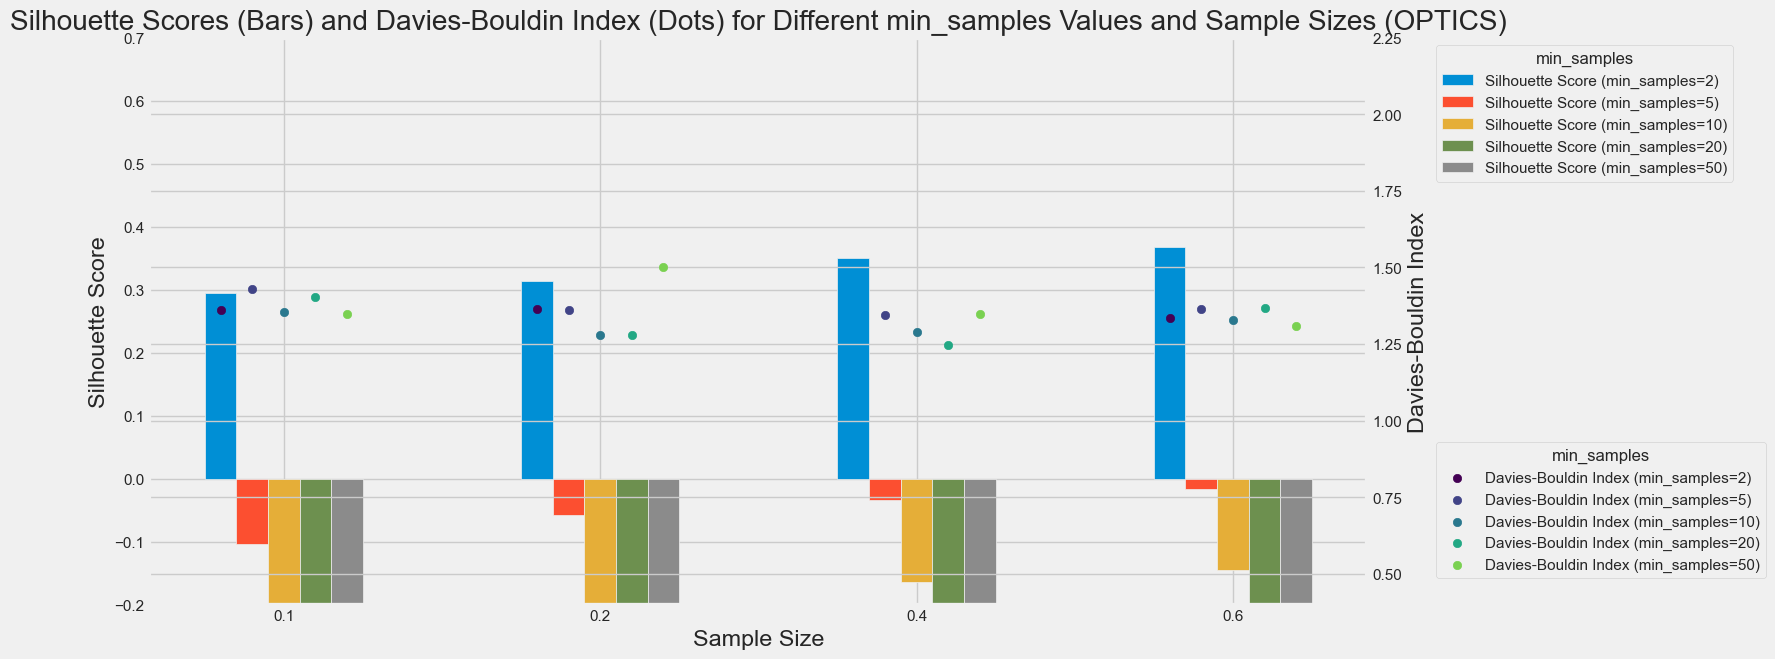

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Define sample ratios and distance metrics to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
min_samples_list = [2, 5, 10, 20, 50]  # Updated min_samples list
silhouette_results = {min_samples: [] for min_samples in min_samples_list}
davies_results = {min_samples: [] for min_samples in min_samples_list}
training_times = {min_samples: [] for min_samples in min_samples_list}

# Sample the data once for all iterations
# Assuming 'scaled_features' is your DataFrame containing the scaled data

# Iterate over each min_samples value
for min_samples in min_samples_list:
    start_time_sampling = time.time()
    # Iterate over each sample ratio
    for ratio in sample_ratios:
        start_time = time.time()
        # Sample a fraction of the data based on the ratio
        features_samples = new.groupby('neighborhood', group_keys=False).apply(lambda x: x.sample(frac=ratio))
        features_scaled_sample = features_samples[['pm25', 'longitude', 'latitude']]   
        
        # Run OPTICS clustering on the sampled and scaled features
        optics = OPTICS(min_samples=min_samples, metric='euclidean')  # Euclidean metric
        optics.fit(features_scaled_sample)
        labels = optics.labels_
        end_time = time.time()
        training_time = end_time - start_time
        
        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[min_samples].append(silhouette_avg)
            davies_results[min_samples].append(davies_avg)
            training_times[min_samples].append(training_time)
        else:
            silhouette_results[min_samples].append(None)  # Only noise points found
            davies_results[min_samples].append(None)
            training_times[min_samples].append(None)

        # Print training time for each case
        print(f"Training Time for min_samples={min_samples}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for silhouette scores for each min_samples value
bar_width = 0.1
index = np.arange(len(sample_ratios))
for i, min_samples in enumerate(min_samples_list):
    ax.bar(index + i * bar_width, silhouette_results[min_samples], bar_width, label=f'Silhouette Score (min_samples={min_samples})')

# Plot Davies-Bouldin Index on secondary y-axis as dots
ax2 = ax.twinx()
for i, min_samples in enumerate(min_samples_list):
    ax2.scatter(index + i * bar_width, davies_results[min_samples], marker='o', label=f'Davies-Bouldin Index (min_samples={min_samples})', color=plt.cm.viridis(i / len(min_samples_list)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores (Bars) and Davies-Bouldin Index (Dots) for Different min_samples Values and Sample Sizes (OPTICS)')
ax.set_xticks(index + bar_width * (len(min_samples_list) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='min_samples', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='min_samples', bbox_to_anchor=(1.05, 0.3), loc='upper left')

# Set y-axis limits
ax.set_ylim(-0.2, 0.7)
ax2.set_ylim(0.4, 2.25)

plt.show()
